In [1]:
from spectral_cube import SpectralCube as sc
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import radio_beam
import os
from astropy.modeling import models, fitting
import time
import pdb
import matplotlib as mpl
from math import log10, floor
from astropy.stats import bootstrap
import astropy.stats
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from utilities import *
from astropy.table import QTable
import matplotlib.patheffects as pe

mpl.interactive(True)
plt.rcParams["figure.dpi"]=150
plt.close('all')

def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))

source='SgrB2S'
molecule=' C2H5OH '
molname=cdmsnamelist[molecule]
fnum=fields[source]
#c2h5oh_sourcelocs={'SgrB2S':'/mar2025_1_removesDS2exclusions/','DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
#                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/','DSVI':'/nov2024_1_removesDS2exclusions/'}
sourcepath=c2h5oh_sourcelocs[source]
pixel=pixdict[source]
home=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}/{sourcepath}'
cCfreqs, cCaij, cCdeg, cCEU, qrot = get_molecular_parameters(molname,catalog='CDMS', fmin=150*u.GHz, fmax=155*u.GHz,)
z=(c2h5oh_dopplershifts[source]/c).to('')

savefigbase=f'/blue/adamginsburg/d.jeff/repos/C2H5OH_SgrB2DS/figures/{source}'
savefighome=savefigbase+sourcepath

debuglabel='ds2exclusions'#sourcepath.replace('/','')
rotdiagpath=savefighome+f'pixelwiserotationaldiagrams/'

if os.path.isdir(rotdiagpath):
    print(f'Rotational diagram folder {rotdiagpath} already exists.')
    pass
else:
    print(f'Making rotational diagram folder {rotdiagpath}')
    os.makedirs(rotdiagpath)
    print('Directory created.\n')

fulltexmap=fits.getdata(home+'texmap_3sigma_allspw_withnans_weighted.fits')
measTrot=fulltexmap[pixel[0],pixel[1]]*u.K
measTrot

Rotational diagram folder /blue/adamginsburg/d.jeff/repos/C2H5OH_SgrB2DS/figures/SgrB2S/mar2025_2_removesDS2exclusions/pixelwiserotationaldiagrams/ already exists.


<Quantity 231.04024652 K>

In [2]:
transition_table=QTable.read(home+'table_of_used_lines_and_parameters.fits')#'mastereuksqnsfreqsdegens.fits')
nupperpaths=transition_table['MeasuredNupperPath'].data
errornupperpaths=transition_table['MeasuredNupperErrorPath'].data
nuppergs=np.array([fits.getdata(x) for x in nupperpaths])[:,pixel[0],pixel[1]]
error_nuppergs=np.array([fits.getdata(x) for x in errornupperpaths])[:,pixel[0],pixel[1]]
euppers=transition_table['Eupper'].value
qns=transition_table['QNs']
reffreqs=transition_table['ReferenceFrequency']

In [3]:
if molecule in incompleteqrot:
    print(f'{molecule} has an incomplete partition function')
    print('Estimating by linear fit to log-log Qrot/T relation')
    poly=Linear1D(slope=150, intercept=10)
    fitter=fitting.LinearLSQFitter()
    fitinput_xvalues=np.linspace(3,300,1000)*u.K
    power_law_fit=fitter(poly,np.log10(fitinput_xvalues.value),np.log10(qrot(fitinput_xvalues)))
    logintercept=10**power_law_fit.intercept
    logTs=logintercept*fitinput_xvalues.value**power_law_fit.slope

qrot_partfunc=fit_qrot(logintercept,measTrot,power_law_fit)


 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation


In [4]:
excludedlines={'SgrB2S':'','DSi':['13(5,8)(2)-13(4,9)(2)','21(5,17)(2)-21(4,18)(2)','20(5,16)(2)-20(4,17)(2)','22(5,18)(2)-22(4,19)(2)'],
               'DSii':['13(5,8)(2)-13(4,9)(2)','21(5,17)(2)-21(4,18)(2)','20(5,16)(2)-20(4,17)(2)','22(5,18)(2)-22(4,19)(2)'],
               'DSiv':['13(5,8)(2)-13(4,9)(2)','21(5,17)(2)-21(4,18)(2)','20(5,16)(2)-20(4,17)(2)','22(5,18)(2)-22(4,19)(2)','13(2,11)(0)-12(2,10)(0)'],
              'DSv':['13(5,8)(2)-13(4,9)(2)','21(5,17)(2)-21(4,18)(2)','20(5,16)(2)-20(4,17)(2)','22(5,18)(2)-22(4,19)(2)','35(4,31)(2)-35(3,32)(2)'],
               'DSVI':['13(5,8)(2)-13(4,9)(2)','21(5,17)(2)-21(4,18)(2)','20(5,16)(2)-20(4,17)(2)','22(5,18)(2)-22(4,19)(2)']}
exclusions=excludedlines[source]
linemod=models.Linear1D(slope=1.0,intercept=14)
fit=fitting.LinearLSQFitter()
nuppergstofit=[]
eukstofit=[]
nuppergerrorstofit=[]
qnstofit=[]
freqsfitted=[]
bootstraps=True
for nupperg, error_nupperg, eupper, qn, freq in zip(nuppergs,error_nuppergs,euppers, qns, reffreqs):
    if nupperg >= 0 and np.isfinite(nupperg) and qn not in exclusions and eupper > 250:#or (nupper_gmaps[transition][y,x]/error_nupper_gmaps[transition][y,x]) < snr:
        nuppergstofit.append(nupperg)
        eukstofit.append(eupper)
        nuppergerrorstofit.append(error_nupperg)
        qnstofit.append(qn)
        freqsfitted.append(freq.value)
if len(nuppergstofit)==0:
    print('No transitions have significant Nupper/g measurements')
else:
    log10nuerr=[]
    weightstofit=[]
    log10variances=[]
    for nuppergtofit,nuppergerrortofit in zip(nuppergstofit,nuppergerrorstofit):
        convert_linear_error_to_log10_error=nuppergerrortofit/nuppergtofit
        tempweight=1/convert_linear_error_to_log10_error#SNR
        log10nuerr.append(convert_linear_error_to_log10_error)
        weightstofit.append(tempweight)
        log10variances.append(convert_linear_error_to_log10_error**2)
    
    fit_lin=fit(linemod,eukstofit,np.log10(nuppergstofit),weights=weightstofit)
    linemod_euks=np.linspace(min(euppers),max(euppers),100)#Goes out to the max Eupper because these values are used for plotting
    obsTrot=-np.log10(np.e)/(fit_lin.slope)
    obsNtot=qrot_partfunc*10**(fit_lin.intercept)

    if bootstraps:
        bslist=[]
        for nug,euk,weight,var in zip(np.log10(nuppergstofit),eukstofit,weightstofit,log10variances):#10
            bslist.append((nug,euk,weight,var))
        
        numboots=1000
        bootresult=bootstrap(np.array(bslist),numboots)
        
        bootlines=[]
        bootTrots=[]
        bootInts=[]#The fitted ntots
        bootNums=[]#The fitted interecepts
        bootSlopes=[]
        for boot in bootresult:
            tempfit=fit(linemod,boot[:,1],boot[:,0],weights=boot[:,2])
            bootlines.append(tempfit)
        for line in bootlines:
            tempbootTrot=-np.log10(np.e)/(line.slope)
            tempbootslope=line.slope.value
            tempbootNtot=qrot_partfunc*10**(line.intercept)
            tempbootintNtot=line.intercept.value
            if line.slope >= 0:#tempbootTrot >= 1000 or tempbootTrot <= 0:
                continue
            else:
                bootTrots.append(tempbootTrot)
                bootInts.append(tempbootNtot)
                bootNums.append(tempbootintNtot)
                bootSlopes.append(tempbootslope)
        
        bootstrap_error_Trot=astropy.stats.mad_std(bootTrots)
        slope_bootstd=astropy.stats.mad_std(bootSlopes)
        madstd_interceptfits=astropy.stats.mad_std(bootNums)
        #interimfactor=fit_lin.intercept.value*(1-madstd_interceptfits)
        #oldpossiblemessedup_bootNstd=qrot_partfunc*10**(interimfactor)
        bootstrap_error_Ntot=astropy.stats.mad_std(bootInts)#((qrot_partfunc*10**(madstd_interceptfits))*np.log(10))
    
    A=np.stack((eukstofit,np.ones_like(eukstofit)),axis=1)
    C=np.diagflat(log10variances)
    atc_1a=np.dot(np.dot(A.T, np.linalg.inv(C)), A)
    if np.linalg.det(atc_1a) == 0:
        #print(f'Singular C matrix detected in pixel {y,x}')
        m_unc=np.nan
    else:
        covmat = np.linalg.inv(atc_1a)
        m_unc = covmat[0,0]**0.5
        b_unc = covmat[1,1]**0.5
    
    dobsTrot=np.abs(np.abs(m_unc/fit_lin.slope)*obsTrot*u.K)
    dobsNtot=np.abs(qrot_partfunc*10**(fit_lin.intercept)*(np.log(10)*b_unc))*u.cm**-2
    sigTrot=(obsTrot*u.K/dobsTrot).to('')
    sigNtot=(obsNtot*u.cm**-2/dobsNtot).to('')

    tk='$T_{rot}$'
    ntot='log$_{10}(N_{tot})$'
    cm2='cm$^{-2}$'
    #strdobsntot=str(dobsNtot.value)[0]
    if not np.isfinite(dobsNtot.value) or dobsNtot <= 0 or obsNtot == 0:
        val_dntot='nan'#np.nan
        if not np.isfinite(obsNtot) or obsNtot <= 0:
            val_ntot=np.nan
        else:
            val_ntot=round(np.log10(obsNtot),2)
    else:
        val_dntot=round_to_1(dobsNtot.value/(1*10**int(np.log10(obsNtot))))
        val_ntot=round(np.log10(obsNtot),1)

    if not np.isfinite(dobsTrot.value):
        dobsTrot=1e5*u.K

In [5]:
restfreqsfitted=(freqsfitted*(1+z))*u.GHz
print(obsTrot/bootstrap_error_Trot)
print(obsNtot/bootstrap_error_Ntot)

2.243813732571328
1.880264222357037


invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'


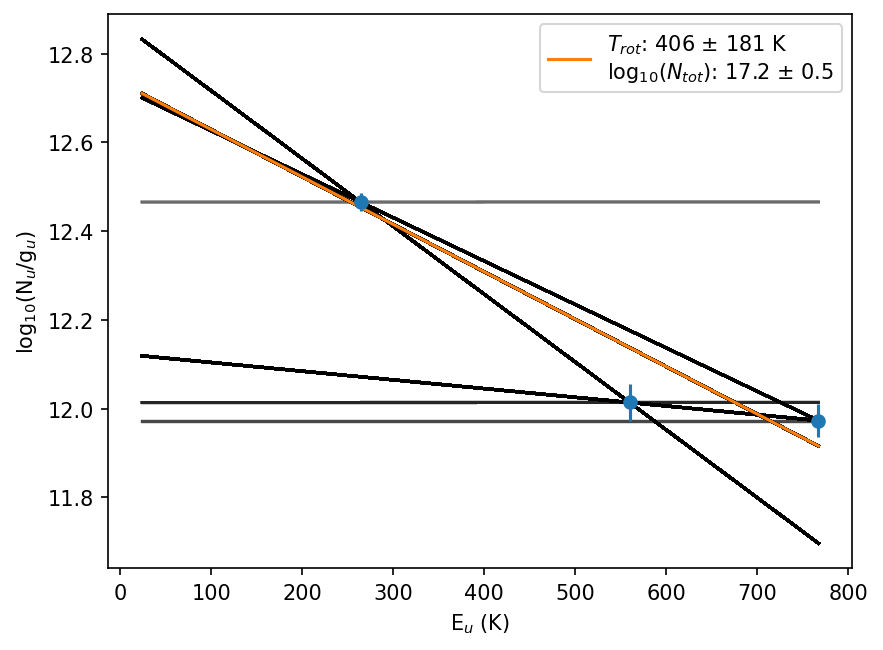

In [6]:
dots=plt.errorbar(eukstofit,np.log10(nuppergstofit),yerr=log10nuerr,fmt='o')
plot_error_Ntot=(bootstrap_error_Ntot/obsNtot)
plt.plot(linemod_euks,fit_lin(linemod_euks),
         label=(f'{tk}: {int(obsTrot)} $\pm$ {int(bootstrap_error_Trot)} K\n{ntot}: {val_ntot} $\pm$ {round(plot_error_Ntot,1)}'))

for linmod in bootlines:
    plt.plot(linemod_euks,linmod(linemod_euks),color='black',alpha=0.03,zorder=0)

plt.xlabel(r'E$_u$ (K)')
plt.ylabel(r'log$_{10}$(N$_u$/g$_u$)')
plt.legend()
#plt.savefig(f'debuggingrotationaldiagrams/{source}_{debuglabel}_bootstrap_interr_{y}_{x}.png')
#plt.savefig(rotdiagpath+f'bootstrap_interr_{pixel[0]}_{pixel[1]}.png')
#qnlegend.write(rotdiagpath+f'qnlegend_{pixel[0]}_{pixel[1]}.fits',overwrite=True)
plt.show()

invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'
invalid escape sequence '\p'


Label           QNs           ...   RestFrequency          Eupper     
                              ...        GHz                 K        
----- ----------------------- ... ------------------ -----------------
    1 35(4,31)(2)-35(3,32)(2) ... 218.94237359837703 559.6887547607863
    2 41(5,36)(2)-41(4,37)(2) ... 230.99568341980847 767.3782930658575
    3 23(5,19)(2)-23(4,20)(2) ... 232.31754289490374 263.9880929132633


Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


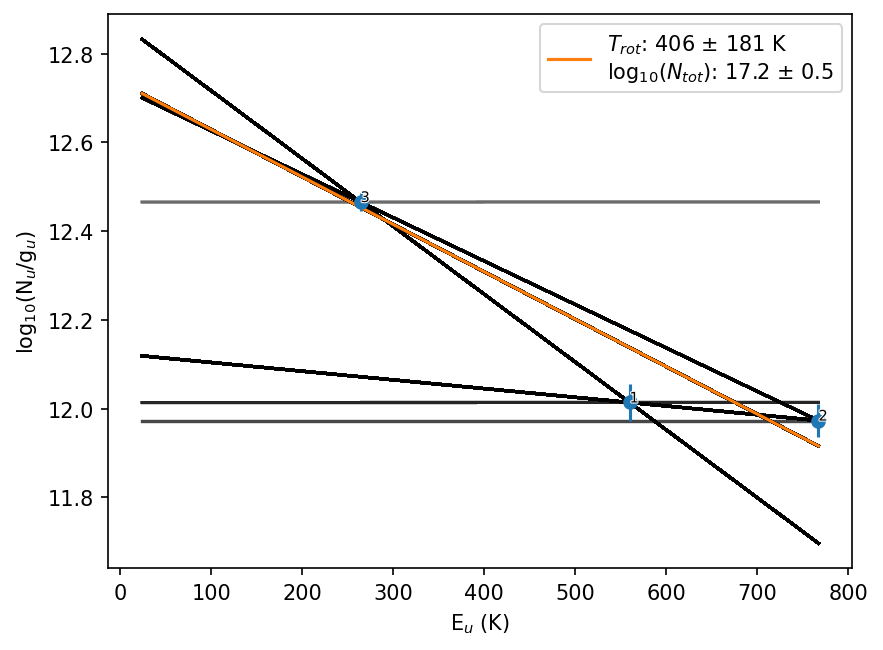

In [7]:
dots=plt.errorbar(eukstofit,np.log10(nuppergstofit),yerr=log10nuerr,fmt='o')
plot_error_Ntot=(bootstrap_error_Ntot/obsNtot)
for eupper,nupper,qn,num in zip(eukstofit,nuppergstofit,qnstofit,np.arange(len(qnstofit))):
    txt=plt.text(eupper,np.log10(nupper),(num+1),fontsize=7,label=qn)
    txt.set_path_effects([pe.withStroke(linewidth=1,foreground='w')])
qnlegend=QTable([(np.arange(len(qnstofit))+1),qnstofit,freqsfitted,restfreqsfitted,eukstofit],units=['','','GHz','GHz','K'],
                names=['Label','QNs','ReferenceFrequency','RestFrequency','Eupper'])
print(qnlegend)
plt.plot(linemod_euks,fit_lin(linemod_euks),
         label=(f'{tk}: {int(obsTrot)} $\pm$ {int(bootstrap_error_Trot)} K\n{ntot}: {val_ntot} $\pm$ {round(plot_error_Ntot,1)}'))

for linmod in bootlines:
    plt.plot(linemod_euks,linmod(linemod_euks),color='black',alpha=0.03,zorder=0)

plt.xlabel(r'E$_u$ (K)')
plt.ylabel(r'log$_{10}$(N$_u$/g$_u$)')
plt.legend()
#plt.savefig(f'debuggingrotationaldiagrams/{source}_{debuglabel}_bootstrap_interr_{y}_{x}.png')
#plt.savefig(rotdiagpath+f'labeled_bootstrap_interr_{pixel[0]}_{pixel[1]}.png')
#qnlegend.write(rotdiagpath+f'qnlegend_{pixel[0]}_{pixel[1]}.fits',overwrite=True)
plt.show()

In [9]:
qnlegend

Label,QNs,ReferenceFrequency,RestFrequency,Eupper
,,GHz,GHz,K
int64,str23,float64,float64,float64
1,"13(0,13)(1)-12(1,12)(1)",217.22236431386827,217.26344776252725,135.54154448503328
2,"13(1,13)(1)-12(0,12)(1)",217.45668423236657,217.49781199814902,135.37352053614035
3,"21(5,16)(2)-21(4,17)(2)",218.51433187579187,218.55565967536364,226.01385361044416
4,"35(4,31)(2)-35(3,32)(2)",218.90304170852855,218.94444302511826,559.6887547607863
5,"13(2,11)(0)-12(2,10)(0)",230.63015498943346,230.67377426483196,138.6199773674354
6,"16(5,11)(2)-16(4,12)(2)",230.91132839356158,230.95500084752274,145.77872777262775
7,"14(0,14)(2)-13(1,13)(2)",230.9489216817492,230.9926012457606,85.52671483307333
8,"14(1,14)(0)-13(1,13)(0)",231.6261556671229,231.66996331696816,141.90345196927348


### transition_table